In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import re
import sys
from tqdm import tqdm
from tensorflow import keras


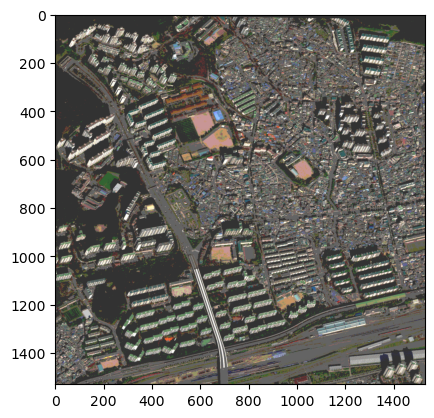

In [2]:

#import pictures and cut into slices
input_path = "../cse-seminar/inputs/tifBusan.tif"
img = cv2.imread(input_path)
img = cv2.convertScaleAbs(img, alpha = 50,beta = 50)
img = cv2.resize(img,(1530,1530))
plt.imshow(img)


# dimensions of the original image
height, width, _ = img.shape

# Define dimensions for each smaller image
small_width = width // 10
small_height = height // 10

# Slice the original image into smaller images
small_images = []
for row in range(10):
    for col in range(10):
        # starting and ending points of each small image
        start_x = col * small_width
        end_x = (col + 1) * small_width
        start_y = row * small_height
        end_y = (row + 1) * small_height

        # Extract from the original image
        small_image = img[start_y:end_y, start_x:end_x]

        # Append small image to list
        small_images.append(small_image)

# save smaller images
output_path = "../cse-seminar/small_images/"
for i, small_image in enumerate(small_images):
    cv2.imwrite( '../cse-seminar/small_images/small_image%d.png' % i, small_image)


In [3]:
# Add Metrics
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou_score = tf.divide(intersection, union)
    return iou_score

In [4]:
# load small images
image_path = []
for root, dirs, files in os.walk('../cse-seminar/small_images_withlabel'):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)

images = []
testimg = []

for path in image_path:
    file = tf.io.read_file(path)
    img = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    testimg.append(img)

100%|██████████| 68/68 [00:00<00:00, 3396.72it/s]


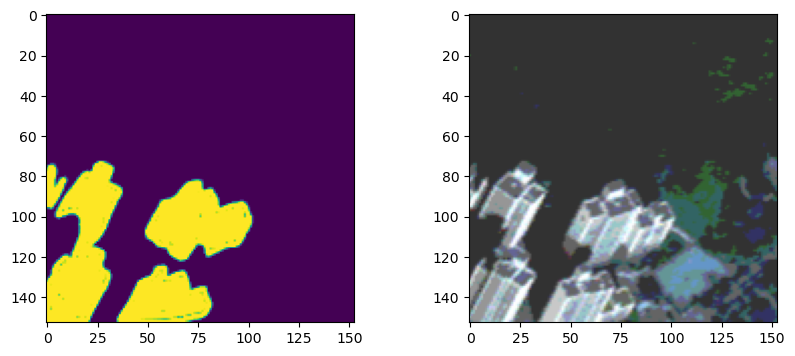

In [5]:
# a list to collect paths masks
mask_path = []
for root, dirs, files in os.walk('../cse-seminar/labeled_data'):
    #iterate over 1000 masks
    for file in files:
        # obtain the path
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)

# create a list to store masks
testmasks = []
# iterate over mask paths
for path in tqdm(mask_path):
    # read the file
    mask = np.load(path)
    # add channel
    mask = mask[..., tf.newaxis]
    # append mask to the list
    testmasks.append(mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(testmasks[2])
ax2.imshow(testimg[2])

In [6]:
# Split data into train and test
def normalize_image(input_image):
    input_image = tf.cast(input_image, tf.float32)
    input_image = input_image/ 255.0
    input_image = tf.image.resize(input_image, (128,128))
    return input_image

def normalize_mask(input_mask):
    input_mask = input_mask/ 255.0
    input_mask = tf.image.resize(input_mask, (128,128))
    input_mask = tf.cast(input_mask, tf.uint8)
    return input_mask

testimg = [normalize_image(i) for i in testimg]
testmasks =  [normalize_mask(m) for m in testmasks]

X_train, X_test, y_train, y_test = train_test_split(testimg, testmasks, test_size=0.2, random_state=42)

X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)

y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

X_train.element_spec, y_train.element_spec, X_test.element_spec, y_test.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [7]:
# adjust brightness of image
# don't alter in mask
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# adjust gamma of image
# don't alter in mask
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

# adjust hue of image
# don't alter in mask
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (128,128))
    # cast to integers as they are class numbers
    mask = tf.cast(mask, tf.uint8)
    return img, mask

# flip both image and mask identically
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

# flip both image and mask identically
def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [8]:
# zip images and masks
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_test, y_test))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

# concatenate every new augmented sets
train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [9]:
BATCH = 5
AT = tf.data.AUTOTUNE
BUFFER = 100

STEPS_PER_EPOCH = 54 //BATCH
VALIDATION_STEPS = 14 //BATCH

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

In [10]:
# Use pre-trained DenseNet121 without head
base = keras.applications.DenseNet121(input_shape=[128,128,3],
                                      include_top=False,
                                      weights='imagenet',
                                      )

In [11]:
len(base.layers)

427

In [12]:
#final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

In [13]:
#output of these layers
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [14]:
#Building the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

In [15]:
!pip install -q git+https://github.com/tensorflow/examples.git --quiet

In [16]:
from tensorflow_examples.models.pix2pix import pix2pix
# Four upstack layers for upsampling sizes
# 4->8, 8->16, 16->32, 32->64
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

In [17]:
upstack[1].layers

In [18]:
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])

# downsample
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(2, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


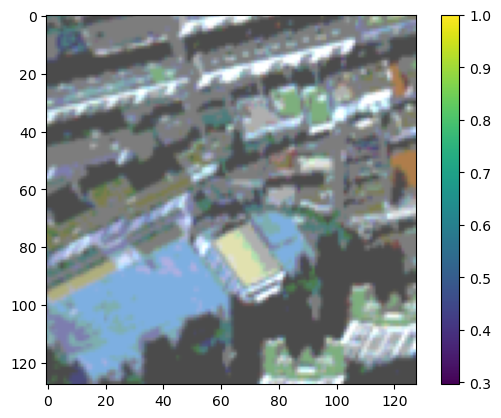

In [19]:
#checking for model and data compatibility
# infer on train dataset
example = next(iter(train))
preds = unet(example[0])
# visualize an image
plt.imshow(example[0][0])
plt.colorbar()
plt.show()

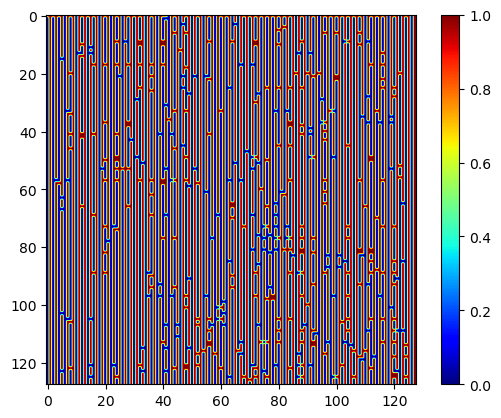

In [20]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0], cmap='jet')
plt.colorbar()

In [34]:
import keras.backend as K

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou_score = tf.divide(intersection, union)
    return iou_score

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [35]:
# compiling the model
def Compile_Model():
    unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                metrics=[iou_coef]
                #metrics=[tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
                 )

Compile_Model()

In [36]:
#training and fine-tuning
hist_1 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=20,
               verbose=2)

Epoch 1/20
10/10 - 25s - loss: 0.0479 - iou_coef: -6.7316e-01 - val_loss: 0.1734 - val_iou_coef: -8.4687e-01 - 25s/epoch - 3s/step
Epoch 2/20
10/10 - 7s - loss: 0.0635 - iou_coef: -8.3088e-01 - val_loss: 0.1720 - val_iou_coef: -7.8398e-01 - 7s/epoch - 747ms/step
Epoch 3/20
10/10 - 8s - loss: 0.0650 - iou_coef: -7.7753e-01 - val_loss: 0.3716 - val_iou_coef: -1.0077e+00 - 8s/epoch - 755ms/step
Epoch 4/20
10/10 - 7s - loss: 0.0698 - iou_coef: -7.4901e-01 - val_loss: 0.2073 - val_iou_coef: -8.4271e-01 - 7s/epoch - 711ms/step
Epoch 5/20
10/10 - 7s - loss: 0.0727 - iou_coef: -6.7886e-01 - val_loss: 0.1796 - val_iou_coef: -8.6992e-01 - 7s/epoch - 719ms/step
Epoch 6/20
10/10 - 7s - loss: 0.0663 - iou_coef: -7.2819e-01 - val_loss: 0.2644 - val_iou_coef: -8.4540e-01 - 7s/epoch - 720ms/step
Epoch 7/20
10/10 - 7s - loss: 0.0798 - iou_coef: -7.5174e-01 - val_loss: 0.2477 - val_iou_coef: -8.6651e-01 - 7s/epoch - 721ms/step
Epoch 8/20
10/10 - 7s - loss: 0.0755 - iou_coef: -7.5966e-01 - val_loss: 0.18

1/1 [==============================] - 2s 2s/step


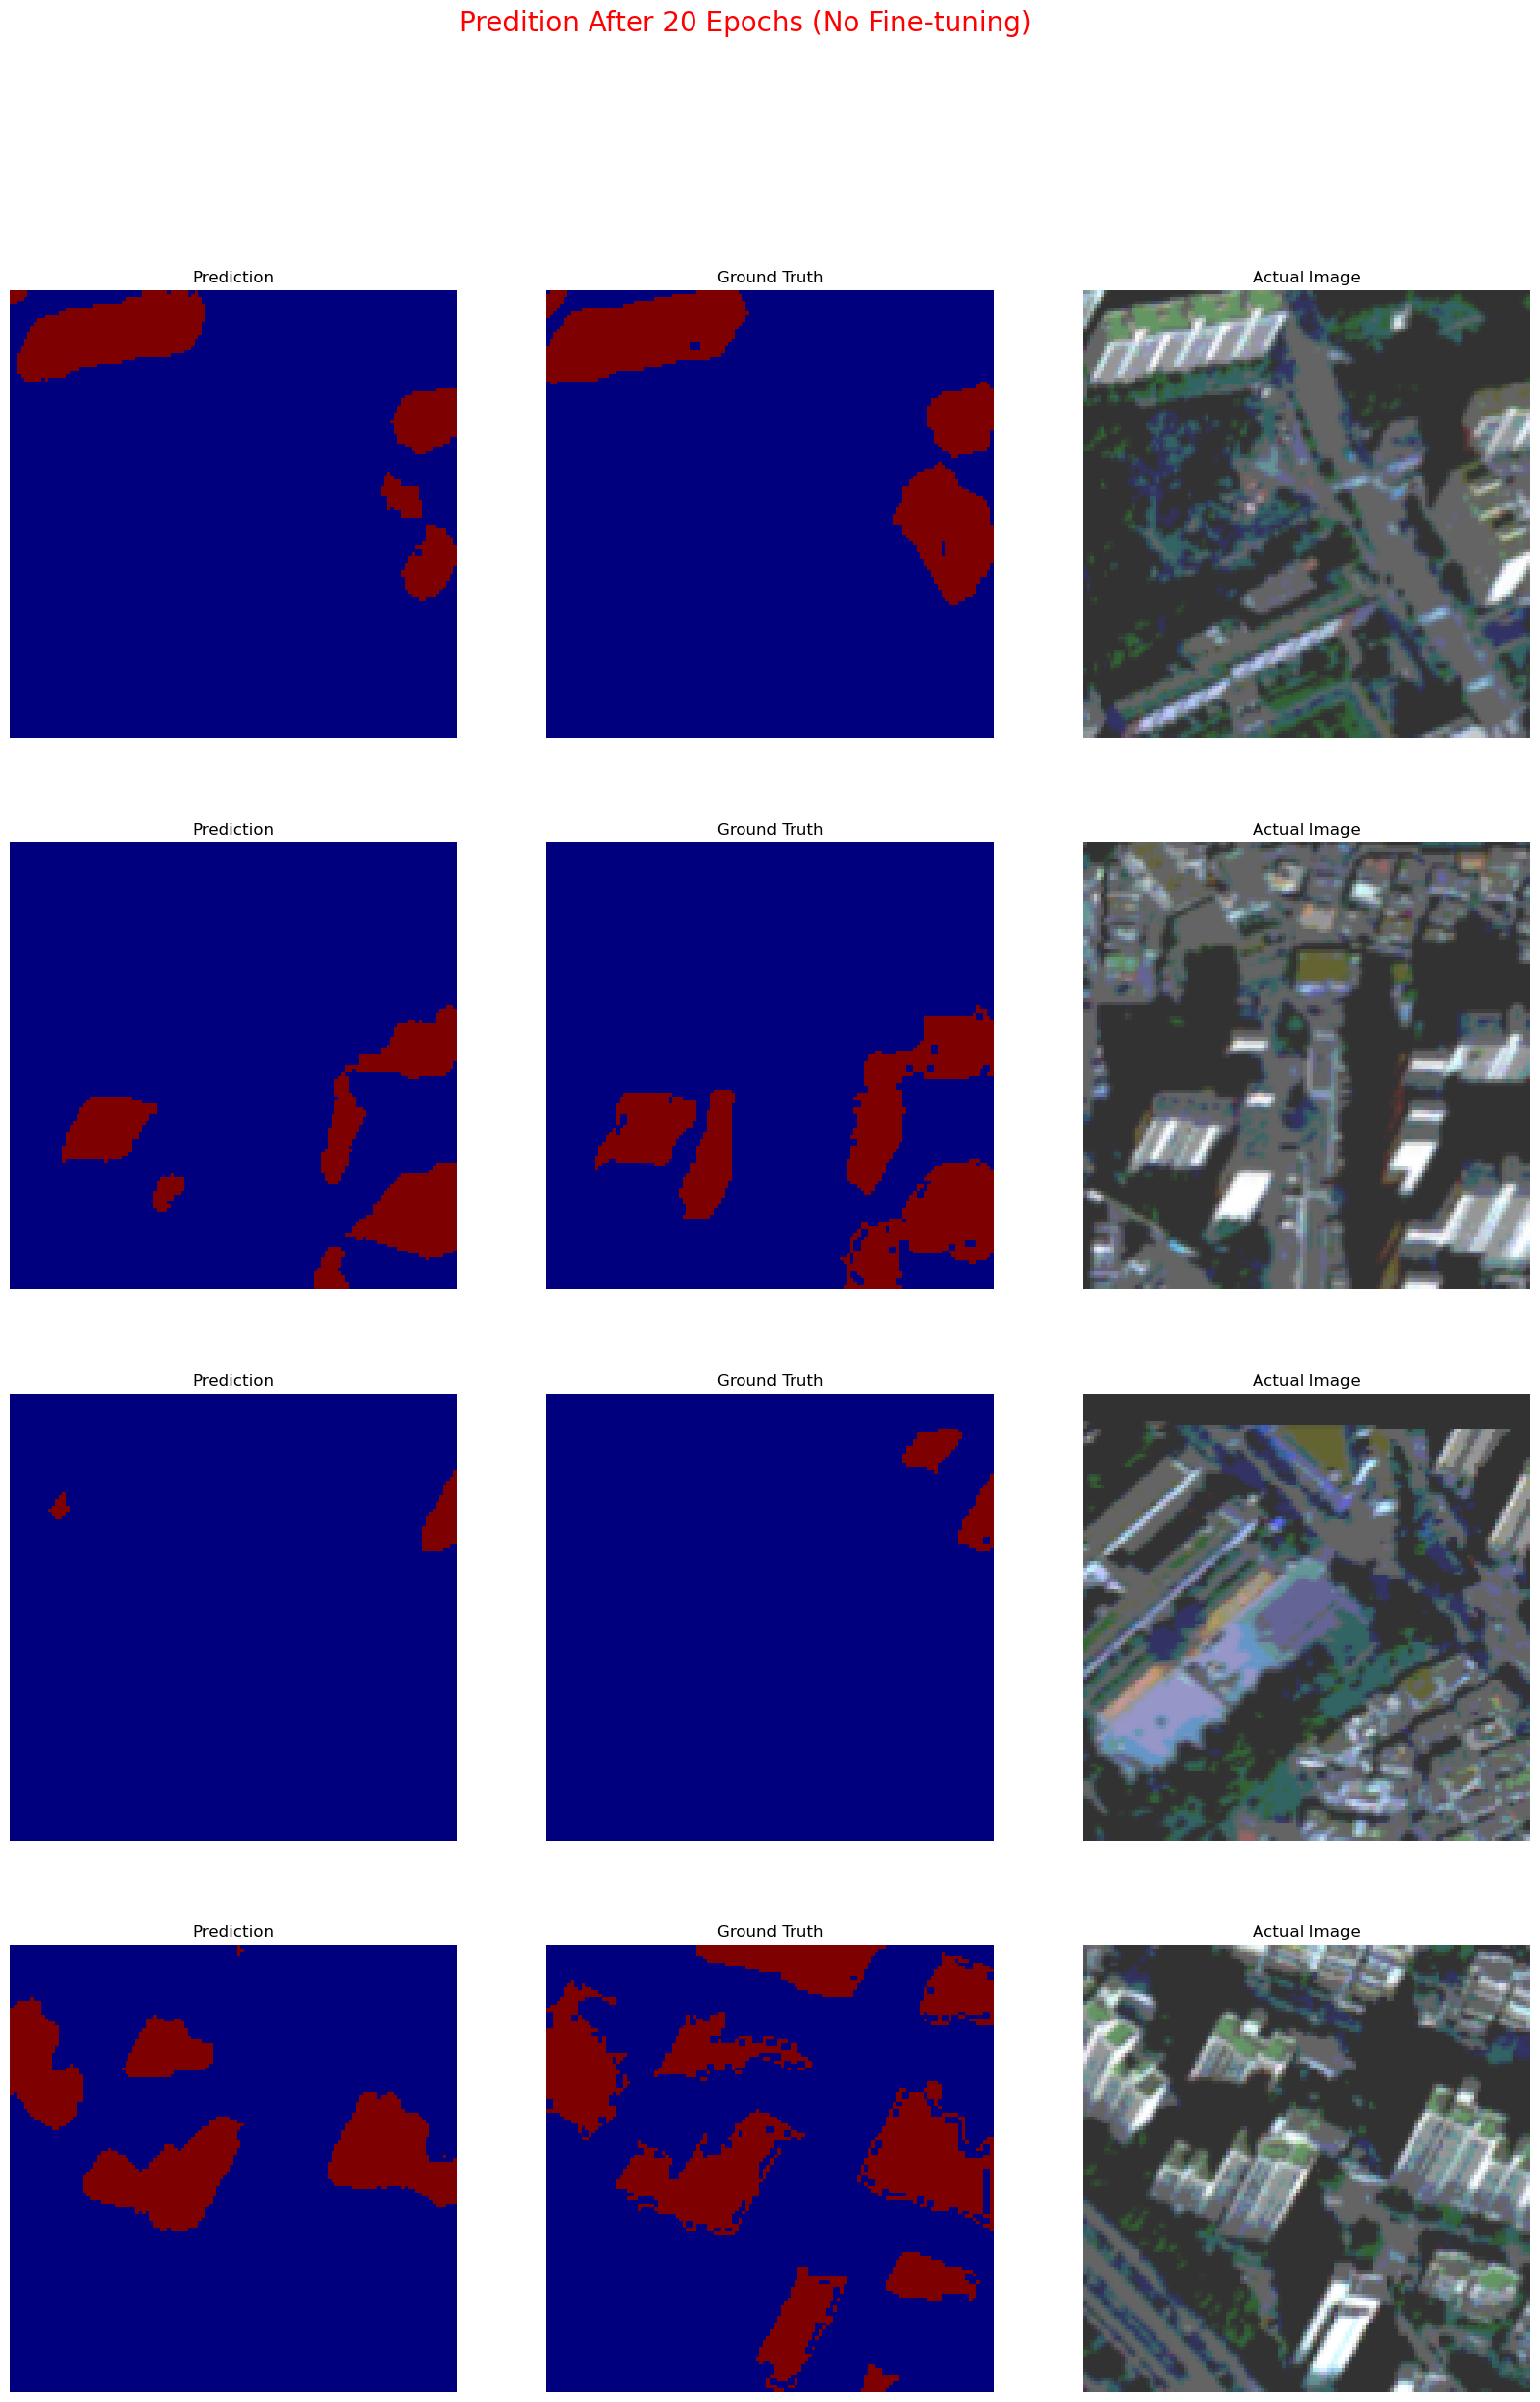

In [37]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 20 Epochs (No Fine-tuning)', color='red', size=20)
plt.show()

In [38]:
downstack.trainable = True
# compile again
Compile_Model()
# train from epoch 20 to 40
hist_2 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=50, initial_epoch = 20,
               verbose = 2
                 )

Epoch 21/50
10/10 - 25s - loss: 0.0499 - iou_coef: -8.0027e-01 - val_loss: 0.2203 - val_iou_coef: -9.0024e-01 - 25s/epoch - 2s/step
Epoch 22/50
10/10 - 8s - loss: 0.0499 - iou_coef: -8.1748e-01 - val_loss: 0.2206 - val_iou_coef: -8.7871e-01 - 8s/epoch - 806ms/step
Epoch 23/50
10/10 - 8s - loss: 0.0544 - iou_coef: -7.2255e-01 - val_loss: 0.1646 - val_iou_coef: -9.3133e-01 - 8s/epoch - 814ms/step
Epoch 24/50
10/10 - 8s - loss: 0.0524 - iou_coef: -6.5269e-01 - val_loss: 0.3981 - val_iou_coef: -9.3571e-01 - 8s/epoch - 822ms/step
Epoch 25/50
10/10 - 8s - loss: 0.0571 - iou_coef: -6.9333e-01 - val_loss: 0.1803 - val_iou_coef: -9.3171e-01 - 8s/epoch - 837ms/step
Epoch 26/50
10/10 - 9s - loss: 0.0628 - iou_coef: -7.3210e-01 - val_loss: 0.1804 - val_iou_coef: -8.5309e-01 - 9s/epoch - 904ms/step
Epoch 27/50
10/10 - 10s - loss: 0.0637 - iou_coef: -7.6895e-01 - val_loss: 0.1766 - val_iou_coef: -8.4345e-01 - 10s/epoch - 959ms/step
Epoch 28/50
10/10 - 10s - loss: 0.0642 - iou_coef: -7.9372e-01 - val

1/1 [==============================] - 2s 2s/step


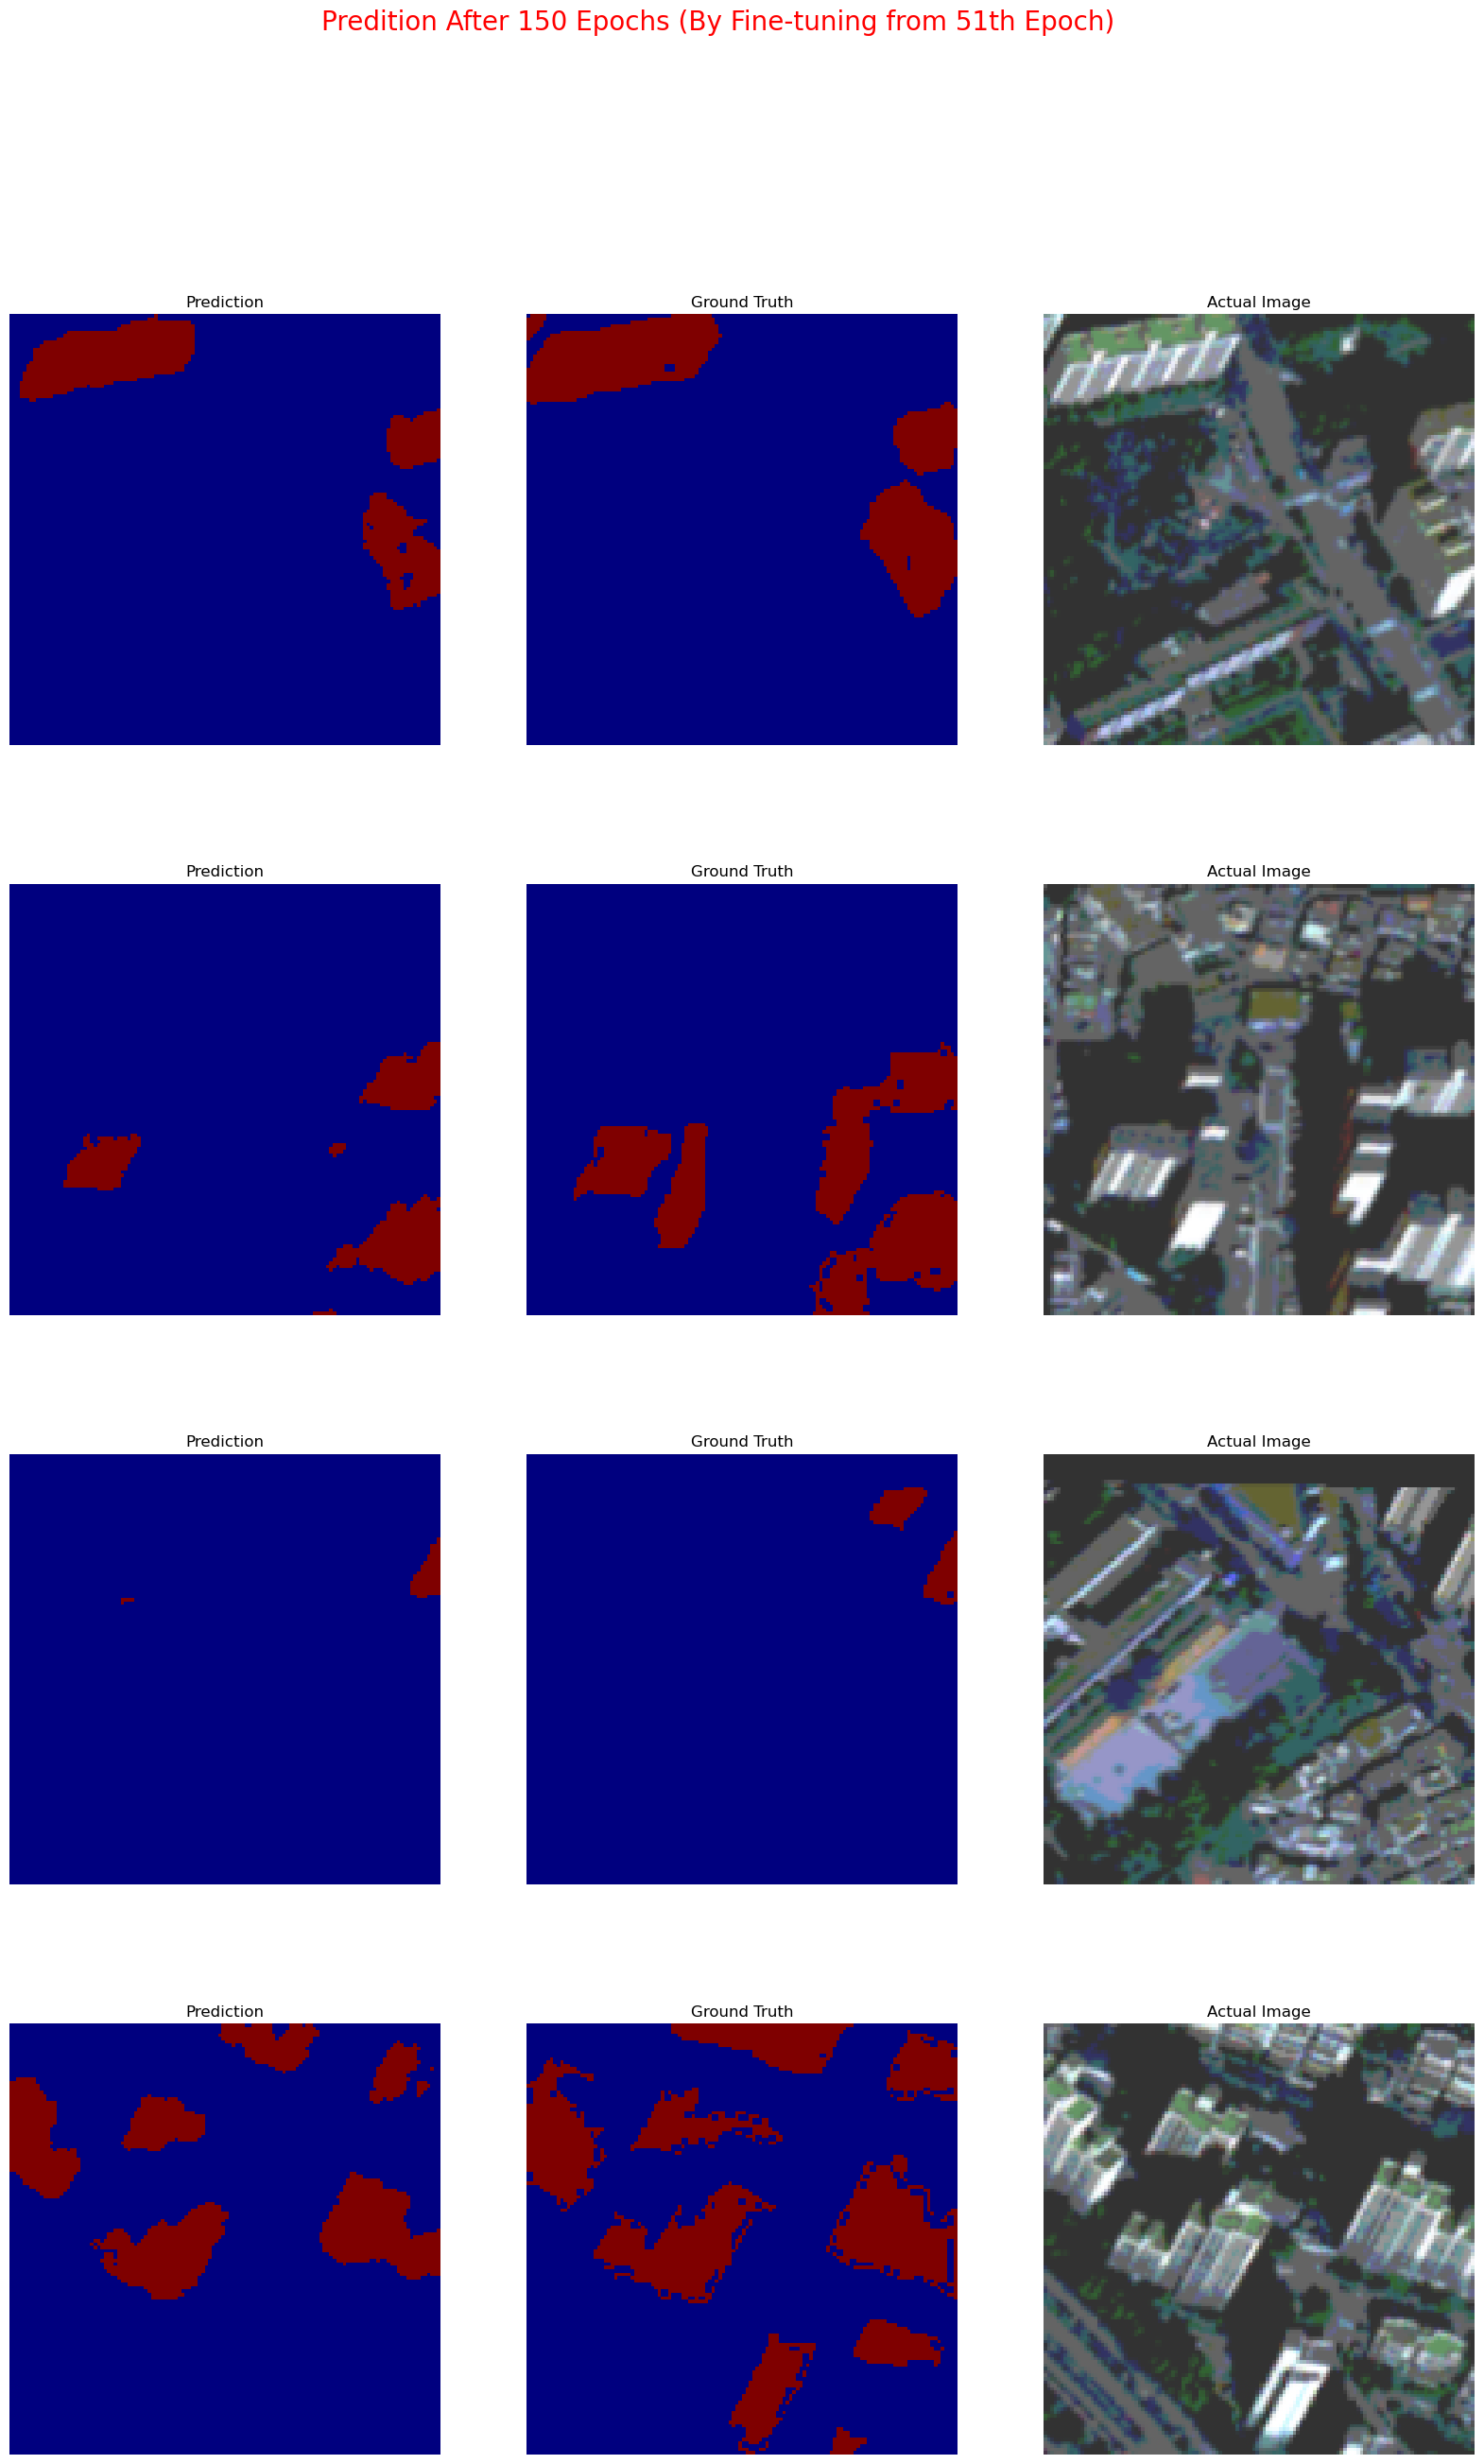

In [39]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 150 Epochs (By Fine-tuning from 51th Epoch)', color='red', size=20)
plt.show()

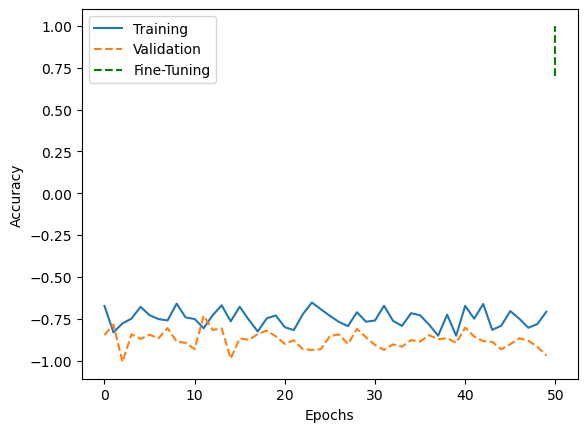

In [41]:
history_1 = hist_1.history
acc=history_1['iou_coef']
val_acc = history_1['val_iou_coef']

history_2 = hist_2.history
acc.extend(history_2['iou_coef'])
val_acc.extend(history_2['val_iou_coef'])

plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.plot([50,50],[0.7,1.0], '--g', label='Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim([0.7,1.0])
plt.legend()
plt.show()